# Spain

In [1]:
import sys
sys.path.insert(0, '../../src')
#   https://realpython.com/python-modules-packages/
sys.path.append('../../src/d01_data')
sys.path.append('../../src/d02_processing')
sys.path.append('../../src/d03_modelling')

import extractions as extract
import transformations as transf
import training as train
import import_data as imp
import inference as inf

crop = 'BLUEBERRIES'
ctry = 'ES'
trade_ctry = 'EU'

In [2]:
# import prices
price = imp.get_prices_junta()
imp.load_prices_bbdd(price)

8  new prices added


In [3]:
# import volumes
imp.load_volumes_bbdd(imp.get_volumes_ibo())

319  new volumes added


In [2]:
# inference model
ctry = 'ES'
crop = 'BLUEBERRIES'
regn = 'ANDALUSIA'
catg = 'std'
pkge = 'bulk'
crcy = 'EUR'
msre = 'KG'
mdel = 'ARIMA'

from dateutil.relativedelta import relativedelta
from datetime import date

start = date.today().strftime('%Y-01-01')
end = (date.today() + relativedelta(years=1)).strftime('%Y-12-31')

df_pred = inf.get_prediction(ctry,crop,regn,catg,pkge,crcy,msre,mdel,start,end)
inf.load_predictions_db(df_pred,ctry,crop,regn,catg,pkge,crcy,msre,mdel)

54  new prices added


In [3]:
# inference model
crop = 'STRAWBERRIES'

from dateutil.relativedelta import relativedelta
from datetime import date

start = date.today().strftime('%Y-01-01')
end = (date.today() + relativedelta(years=1)).strftime('%Y-12-31')

df_pred = inf.get_prediction(ctry,crop,regn,catg,pkge,crcy,msre,mdel,start,end)
inf.load_predictions_db(df_pred,ctry,crop,regn,catg,pkge,crcy,msre,mdel)

53  new prices added


In [4]:
# inference model
crop = 'RASPBERRIES'

from dateutil.relativedelta import relativedelta
from datetime import date

start = date.today().strftime('%Y-01-01')
end = (date.today() + relativedelta(years=1)).strftime('%Y-12-31')

df_pred = inf.get_prediction(ctry,crop,regn,catg,pkge,crcy,msre,mdel,start,end)
inf.load_predictions_db(df_pred,ctry,crop,regn,catg,pkge,crcy,msre,mdel)

86  new prices added


# USA

In [3]:
# 01_data us

crop = 'BLUEBERRIES'
crop_abb = 'BLUBY'

# import prices
price = imp.get_prices_usda(crop,crop_abb)
imp.load_prices_bbdd(price)

# read data
#...

462  new prices added


In [8]:
# 01_data us

# import volumes

crop = 'BLUEBERRIES'
crop_abb = 'BLUBY'
imp.load_volumes_bbdd(imp.get_volumes_usda(crop,crop_abb))

1143  new volumes added


In [9]:
crop = 'RASPBERRIES'
crop_abb = 'RASP'
imp.load_volumes_bbdd(imp.get_volumes_usda(crop,crop_abb))

754  new volumes added


In [10]:
crop = 'STRAWBERRIES'
crop_abb = 'STRBY'
imp.load_volumes_bbdd(imp.get_volumes_usda(crop,crop_abb))

423  new volumes added


ARIMA(8, 0, 1) MAE=0.488
Best ARIMA(8, 0, 1) MAE=0.488


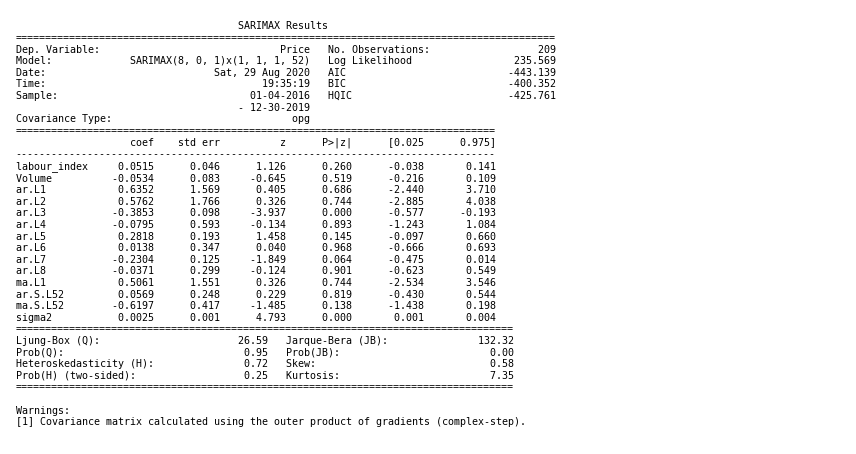

In [3]:
# 03_training
train.train_sarimax_model(crop,ctry,trade_ctry)